In [8]:
import os
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import DenseNet201
from tensorflow.keras.layers import Dropout, Dense, GlobalAveragePooling2D, Conv2D, BatchNormalization, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.activations import swish
from tensorflow.keras.models import Model
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
df = pd.read_csv("DataSet/HAM.csv")
df['image_id'] = df['image_id'].apply(lambda x: x + ".jpg")
class_counts = df['dx'].value_counts()

# Print the counts for each class
print(class_counts)

dx
bkl      7000
nv       7000
df       7000
mel      7000
vasc     7000
bcc      7000
akiec    7000
Name: count, dtype: int64


In [3]:
# Define image dimensions and batch size
img_size = (100, 100)
batch_size = 16

# Create data generators for augmentation
datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

In [4]:
train_df, test_valid_df = train_test_split(df, test_size=0.3, random_state=42)
test_df, valid_df = train_test_split(test_valid_df, test_size=0.5, random_state=42)
train_df['image_id'] = 'DataSet/Combined/' + train_df['image_id']
valid_df['image_id'] = 'DataSet/Combined/' + valid_df['image_id']
test_df['image_id'] = 'DataSet/Combined/' + test_df['image_id']

In [5]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    zoom_range=0.2
)

valid_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    x_col='image_id',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

valid_generator = valid_datagen.flow_from_dataframe(
    valid_df,
    x_col='image_id',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    test_df,
    x_col='image_id',
    y_col='dx',
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

Found 34300 validated image filenames belonging to 7 classes.
Found 7350 validated image filenames belonging to 7 classes.
Found 7350 validated image filenames belonging to 7 classes.


In [9]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(img_size[0], img_size[1], 3))



x = base_model.output
x = Conv2D(64, (3, 3), activation='relu')(x)
x = BatchNormalization()(x)
x = GlobalAveragePooling2D()(x)

x = Dropout(0.5)(x)
x = Dense(1024, activation=swish)(x)
x = Dropout(0.5)(x)
x = Flatten()(x)
x = Dense(128, activation='relu')(x)

predictions = Dense(7, activation='softmax')(x)  # Replace NUM_CLASSES with the number of classes

model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=150,  
    steps_per_epoch=len(train_generator),
    validation_steps=len(valid_generator)
)

Epoch 1/150
2144/2144 [==============================] - 429s 176ms/step - loss: 1.5199 - accuracy: 0.3956 - val_loss: 1.2697 - val_accuracy: 0.4844
Epoch 2/150
2144/2144 [==============================] - 351s 164ms/step - loss: 1.2929 - accuracy: 0.4987 - val_loss: 1.1317 - val_accuracy: 0.5659
Epoch 3/150
2144/2144 [==============================] - 353s 164ms/step - loss: 1.1898 - accuracy: 0.5437 - val_loss: 1.1276 - val_accuracy: 0.5444
Epoch 4/150
2144/2144 [==============================] - 353s 165ms/step - loss: 1.1268 - accuracy: 0.5717 - val_loss: 1.4860 - val_accuracy: 0.5027
Epoch 5/150
2144/2144 [==============================] - 350s 163ms/step - loss: 1.0716 - accuracy: 0.5940 - val_loss: 0.9533 - val_accuracy: 0.6279
Epoch 6/150
2144/2144 [==============================] - 352s 164ms/step - loss: 1.0272 - accuracy: 0.6124 - val_loss: 0.9338 - val_accuracy: 0.6373
Epoch 7/150
2144/2144 [==============================] - 349s 163ms/step - loss: 0.9979 - accuracy: 0.6294

In [12]:
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f'Test accuracy: {test_accuracy * 100:.2f}%')

460/460 [==============================] - 45s 97ms/step - loss: 0.3334 - accuracy: 0.8948
Test accuracy: 89.48%


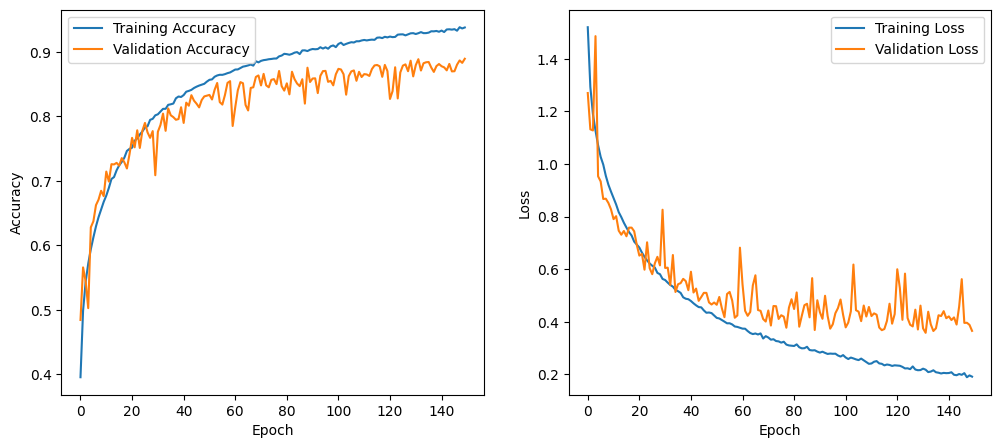

In [13]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [14]:
model.save('Final_DenseNet_model.h5')